In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.metrics import (confusion_matrix, roc_curve, f1_score, recall_score,precision_score, 
                             precision_recall_curve, average_precision_score, roc_auc_score)
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
train_df = pd.read_excel("Train Fraud.xlsx")
test_df = pd.read_excel("Test Fraud - Alunos.xlsx")

ids = test_df['ID']

target = 'Fraude'
features = [col for col in train_df.columns if col != target]

In [4]:
train_df.shape

(255000, 9)

In [5]:
test_df.shape

(45000, 10)

In [3]:
numerical_cols = train_df[features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = train_df[features].select_dtypes(include=['object', 'category']).columns.tolist()

train_df[numerical_cols] = train_df[numerical_cols].fillna(train_df[numerical_cols].mean())
test_df[numerical_cols] = test_df[numerical_cols].fillna(train_df[numerical_cols].mean())

train_df[categorical_cols] = train_df[categorical_cols].fillna("desconhecido")
test_df[categorical_cols] = test_df[categorical_cols].fillna("desconhecido")

low_cardinality = [col for col in categorical_cols if train_df[col].nunique() <= 10]
high_cardinality = [col for col in categorical_cols if train_df[col].nunique() > 10]

for col in high_cardinality:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])

train_df = pd.get_dummies(train_df, columns=low_cardinality)
test_df = pd.get_dummies(test_df, columns=low_cardinality)

train_df, test_df = train_df.align(test_df, join='left', axis=1, fill_value=0)

In [4]:
X = train_df.drop(columns=[target])
y = train_df[target]
X_test_final = test_df.copy()
if 'Fraude' in X_test_final.columns:
    X_test_final = X_test_final.drop(columns=['Fraude'])

corrs = X.corrwith(y).abs()
suspect_vars = corrs[corrs > 0.99].index.tolist()
if suspect_vars:
    print("Removendo variáveis com alta correlação com o target:", suspect_vars)
    X.drop(columns=suspect_vars, inplace=True)
    X_test_final.drop(columns=[col for col in suspect_vars if col in X_test_final.columns], inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test_final)

pca = PCA(n_components=0.995, svd_solver='full')
X_selected = pca.fit_transform(X_scaled)
X_test_selected = pca.transform(X_test_scaled)

smote = SMOTE(sampling_strategy=0.3, random_state=42, k_neighbors=3)
X_train, y_train = smote.fit_resample(X_selected, y)

# Embaralhar as features para evitar que o modelo decore a ordem
shuffle_idx = np.random.permutation(X_train.shape[0])
X_train = X_train[shuffle_idx]
y_train = y_train.iloc[shuffle_idx].reset_index(drop=True)

In [5]:
'''scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# LightGBM Pipeline
model_lgbm = Pipeline(steps=[
	('model', LGBMClassifier(
		objective=,                # Define o problema como classificação binária
		boosting_type=,              # Tipo de boosting: Gradient Boosting Decision Tree
		random_state=,                   # Semente para reprodutibilidade
		n_jobs=,                         # Usa todos os núcleos disponíveis
		n_estimators=,                  # Número de árvores (mais árvores suavizam curvas, mas podem aumentar overfitting)
		learning_rate=,                # Taxa de aprendizado (menor = aprendizado mais lento, menos overfitting)
		max_depth=,                       # Profundidade máxima das árvores (menor = menos overfitting)
		num_leaves=,                      # Número máximo de folhas por árvore (menos folhas = mais regularização)
		min_child_samples=,              # Mínimo de amostras em uma folha (aumentar = mais regularização)
		min_child_weight=,             # Peso mínimo em uma folha (aumentar = evita folhas pequenas e overfitting)
		subsample=,                     # Fração de amostras para cada árvore (menor = mais robustez, menos overfitting)
		colsample_bytree=,              # Fração de features para cada árvore (menor = mais robustez, menos overfitting)
		scale_pos_weight=, #		 Peso da classe minoritária (ajusta desbalanceamento)
		reg_alpha=,                     # Regularização L1 (aumentar = mais penalização, menos overfitting)
		reg_lambda=,                   # Regularização L2 (aumentar = mais penalização, menos overfitting)
		verbose=                        # Suprime logs
	))
])

# XGBoost Pipeline
model_xgb = Pipeline(steps=[
	('model', XGBClassifier(
		use_label_encoder=,            # Não usa o label encoder interno do XGBoost
		eval_metric=,              # Métrica de avaliação (logloss para classificação binária)
		random_state=,                    # Semente para reprodutibilidade
		scale_pos_weight=, # Peso da classe minoritária (ajusta desbalanceamento)
		learning_rate=,                 # Taxa de aprendizado (menor = aprendizado mais lento, menos overfitting)
		max_depth=,                        # Profundidade máxima das árvores (menor = menos overfitting)
		n_estimators=,                   # Número de árvores (mais árvores suavizam curvas, mas podem aumentar overfitting)
		subsample=,                      # Fração de amostras para cada árvore (menor = mais robustez, menos overfitting)
		colsample_bytree=,               # Fração de features para cada árvore (menor = mais robustez, menos overfitting)
		reg_alpha=,                      # Regularização L1 (aumentar = mais penalização, menos overfitting)
		reg_lambda=,                    # Regularização L2 (aumentar = mais penalização, menos overfitting)
		min_child_weight=,              # Peso mínimo em uma folha (aumentar = evita folhas pequenas e overfitting)
		verbosity=                         # Suprime logs
	))
])

models = {'LightGBM': model_lgbm, 'XGBoost': model_xgb}'''

"scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()\n\n# LightGBM Pipeline\nmodel_lgbm = Pipeline(steps=[\n\t('model', LGBMClassifier(\n\t\tobjective=,                # Define o problema como classificação binária\n\t\tboosting_type=,              # Tipo de boosting: Gradient Boosting Decision Tree\n\t\trandom_state=,                   # Semente para reprodutibilidade\n\t\tn_jobs=,                         # Usa todos os núcleos disponíveis\n\t\tn_estimators=,                  # Número de árvores (mais árvores suavizam curvas, mas podem aumentar overfitting)\n\t\tlearning_rate=,                # Taxa de aprendizado (menor = aprendizado mais lento, menos overfitting)\n\t\tmax_depth=,                       # Profundidade máxima das árvores (menor = menos overfitting)\n\t\tnum_leaves=,                      # Número máximo de folhas por árvore (menos folhas = mais regularização)\n\t\tmin_child_samples=,              # Mínimo de amostras em uma folha (aumentar = mais regularizaçã

In [9]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# LightGBM - Configuração final com regularização mais forte
model_lgbm = Pipeline(steps=[
    ('model', LGBMClassifier(
        objective='binary',
        boosting_type='gbdt',
        random_state=42,
        n_jobs=-1,
        n_estimators=1500,
        learning_rate=0.05,
        max_depth=3,                    # menor profundidade
        num_leaves=8,                   # menos folhas
        min_child_samples=200,          # exige mais amostras por folha
        min_child_weight=20.0,          # folhas mais pesadas
        subsample=0.5,                  # menos amostragem (mais robustez)
        colsample_bytree=0.5,
        scale_pos_weight=scale_pos_weight,
        reg_alpha=20.0,                 # regularização L1 mais forte
        reg_lambda=20.0,                # regularização L2 mais forte
        verbose=-1
    ))
])

# XGBoost - Configuração equivalente com regularização mais forte
model_xgb = Pipeline(steps=[
    ('model', XGBClassifier(
        use_label_encoder=False,
        eval_metric='auc',
        random_state=42,
        n_estimators=1500,
        learning_rate=0.05,
        max_depth=3,                    # menor profundidade
        min_child_weight=20.0,          # exige somas maiores nos nós
        subsample=0.5,
        colsample_bytree=0.5,
        scale_pos_weight=scale_pos_weight,
        reg_alpha=20.0,
        reg_lambda=20.0,
        verbosity=0,
        n_jobs=-1
    ))
])

# Dicionário final de modelos
models = {'LightGBM': model_lgbm, 'XGBoost': model_xgb}



Modelo: LightGBM
Precision: 0.9920, Recall: 0.9962, F1: 0.9941, AUC: 0.9999

Modelo: XGBoost
Precision: 0.9903, Recall: 0.9957, F1: 0.9930, AUC: 0.9999


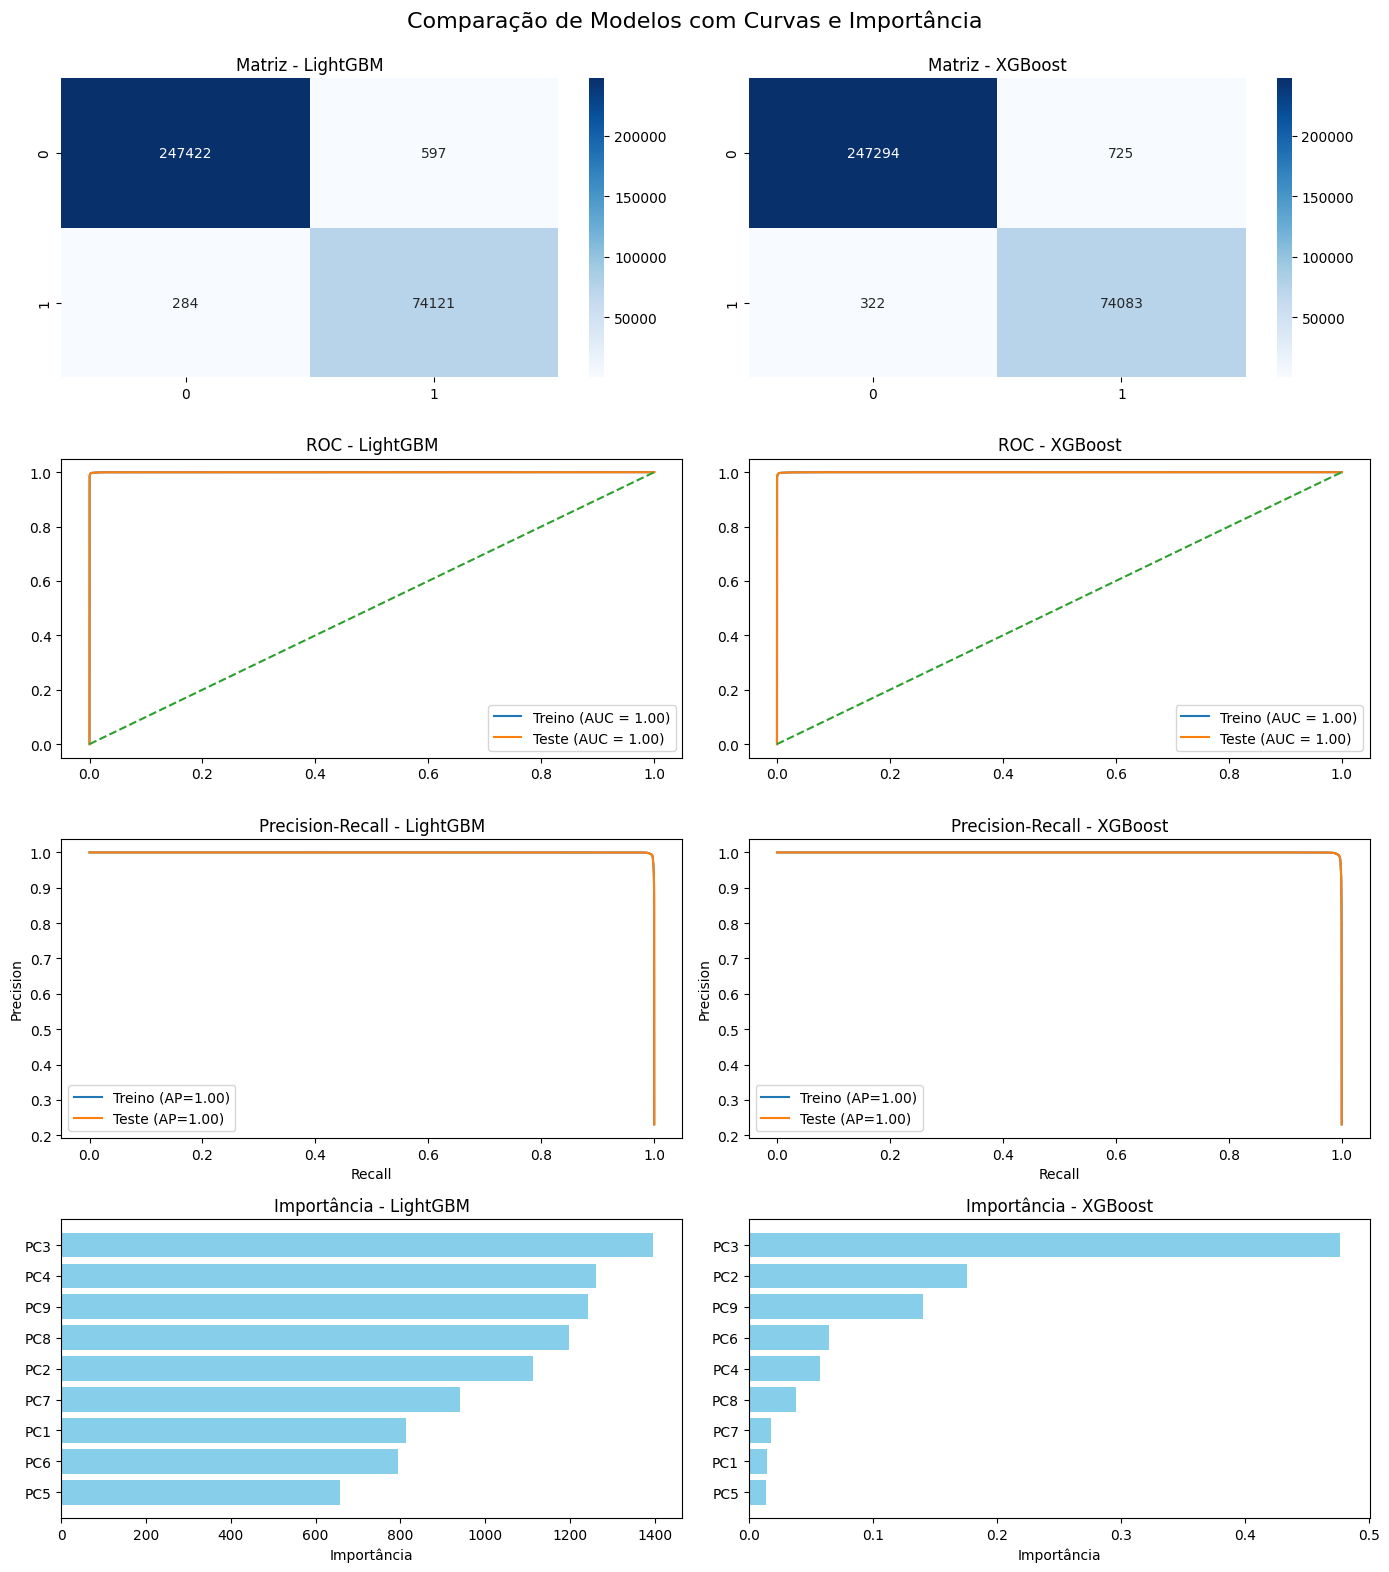

In [10]:
def comparar_modelos_cv(modelos, X_train, y_train, X_val, y_val):
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 16))

    for i, (nome, modelo) in enumerate(modelos.items()):
        modelo.fit(X_train, y_train)
        y_train_proba = modelo.predict_proba(X_train)[:, 1]
        y_val_proba = modelo.predict_proba(X_val)[:, 1]
        y_val_pred = (y_val_proba >= 0.5).astype(int)

        precision_val = precision_score(y_val, y_val_pred)
        recall_val = recall_score(y_val, y_val_pred)
        f1_val = f1_score(y_val, y_val_pred)
        auc_val = roc_auc_score(y_val, y_val_proba)

        sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt='d', cmap='Blues', ax=axes[0, i])
        axes[0, i].set_title(f"Matriz - {nome}")

        # ROC Curve
        fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
        fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
        auc_train = roc_auc_score(y_train, y_train_proba)
        axes[1, i].plot(fpr_train, tpr_train, label=f"Treino (AUC = {auc_train:.2f})")
        axes[1, i].plot(fpr_val, tpr_val, label=f"Teste (AUC = {auc_val:.2f})")
        axes[1, i].plot([0, 1], [0, 1], linestyle='--')
        axes[1, i].legend()
        axes[1, i].set_title(f'ROC - {nome}')

        precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_proba)
        precision_test, recall_test, _ = precision_recall_curve(y_val, y_val_proba)
        ap_train = average_precision_score(y_train, y_train_proba)
        ap_test = average_precision_score(y_val, y_val_proba)
        axes[2, i].plot(recall_train, precision_train, label=f'Treino (AP={ap_train:.2f})')
        axes[2, i].plot(recall_test, precision_test, label=f'Teste (AP={ap_test:.2f})')
        axes[2, i].set_title(f'Precision-Recall - {nome}')
        axes[2, i].set_xlabel('Recall')
        axes[2, i].set_ylabel('Precision')
        axes[2, i].legend()

        # Importância das features no espaço PCA não é diretamente interpretável como no RFE,
        # mas podemos mostrar a importância relativa dos componentes principais.
        if hasattr(modelo.named_steps['model'], 'feature_importances_'):
            importances = modelo.named_steps['model'].feature_importances_
            # Nomes dos componentes principais do PCA
            n_components = X_train.shape[1]
            feature_names = [f'PC{i+1}' for i in range(n_components)]
            # Ordenar por importância (do mais importante para o menos)
            sorted_idx = np.argsort(importances)[::-1]
            sorted_names = np.array(feature_names)[sorted_idx]
            sorted_importances = importances[sorted_idx]
            axes[3, i].barh(sorted_names[::-1], sorted_importances[::-1], color='skyblue')
            axes[3, i].set_title(f'Importância - {nome}')
            axes[3, i].set_xlabel('Importância')
        print(f"\nModelo: {nome}")
        print(f"Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1: {f1_val:.4f}, AUC: {auc_val:.4f}")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.suptitle("Comparação de Modelos com Curvas e Importância", fontsize=16)
    plt.show()

comparar_modelos_cv(models, X_train, y_train, X_train, y_train)

In [11]:
model_lgbm.fit(X_train, y_train)
final_probs = model_lgbm.predict_proba(X_test_selected)[:, 1]
final_preds = pd.DataFrame({
	'ID': ids,
	'Fraude_Prevista': (final_probs >= 0.5).astype(int)
})

submission = final_preds
submission.to_excel("submissao_final.xlsx", index=False)